In [1]:
import sys
import numpy as np
sys.path.append('../..')
from lib.tree_ensemble_training.german_rf import get_model
from lib.tree_extractor import path_extractor
clf, (X_train, y_train, X_test, y_test, data_table), dataset, model, parameters = get_model()
paths = path_extractor(clf, 'random forest', (X_train, y_train))

target = 'credit_risk'
X = data_table.drop(target, axis=1).values
y = data_table[target].values
from lib.tree_extractor import assign_samples
assign_samples(paths, (X, y))

features = data_table.columns[1:]
new_feature = {}
feature_pos = {}
for index, feature in enumerate(features):
    if ' - ' in feature:
        name, p = feature.split(' - ')
        p = int(p)
        if name not in new_feature:
            new_feature[name] = []
        while p >= len(new_feature[name]):
            new_feature[name].append(-1)
        new_feature[name][p] = index
    else:
        new_feature[feature] = [index]

feature_range = {}
for key in new_feature:
    if key in data_table.columns:
        feature_range[key] = [data_table[key].min(), data_table[key].max() + 1]
    else:
        feature_range[key] = [0, len(new_feature[key])]
    for i, j in enumerate(new_feature[key]):
        feature_pos[j] = (key, i)

for index, path in enumerate(paths):
    path['index'] = index

paths = [path for path in paths if np.sum(path['sample']) > 0]

mat = np.array([p['sample'] for p in paths]).astype('float')

for i, path in enumerate(paths):
    sum = np.sqrt(np.sum(mat[i]))
    if sum > 0:
        mat[i] /= sum

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [2]:
sys.path.append('../..')
from lib.data_encoding import german_credit_encoding

output_labels = ['reject', 'accept']
current_encoding = german_credit_encoding

def interpret_path(path):
    conds = {}
    for k in path['range']:
        name = feature_pos[k][0]
        val = path['range'][k]
        if name in current_encoding:
            if name not in conds:
                conds[name] = [1] * len(current_encoding[name])
            if name in data_table.columns:
                for i in range(feature_range[name][0], feature_range[name][1]):
                    if i < val[0] or i > val[1]:
                        conds[name][i - feature_range[name][0]] = 0
            else:
                if val[0] > 0:
                    conds[name] = [0] * len(current_encoding[name])
                    conds[name][feature_pos[k][1]] = 1
                else:
                    conds[name][feature_pos[k][1]] = 0
        else:
            cond = [max(feature_range[name][0], val[0]), min(feature_range[name][1], val[1])]
            conds[name] = cond

    output_conds = []
    for name in conds:
        val = conds[name]
        op = 'is'
        value = ''
        if name in current_encoding:
            is_negation = np.sum(val) * 2 >= len(val) and len(val) > 2
            if is_negation:
                op = 'is not'
                for i, d in enumerate(val):
                    if d == 0:
                        value = value + ' and ' + current_encoding[name][i]
                value = value[5:]
            else:
                for i, d in enumerate(val):
                    if d == 1:
                        value = value + ' or ' + current_encoding[name][i]
                value = value[4:]
        else:
            if val[0] == feature_range[name][0]:
                op = '<='
                value = int(val[1])
            elif val[1] == feature_range[name][1]:
                op = '>='
                value = int(val[0])
            else:
                op = 'in'
                value = '%d to %d' % (int(val[0]), int(val[1]))
        output_conds.append((name, op, value))
    output_label = output_labels[path['output']]
    # print(output_labels, path['output'])
    # print(conds)
    return output_conds, output_label

In [3]:

import matplotlib.pyplot as plt
x_tsne = np.load('path_tsne.npy')

In [4]:
from sklearn.metrics import pairwise_distances

import numpy as np
import math

from typing import Union


def run_loci(data: np.ndarray, alpha: float = 0.5, k: int = 3):
    """Run the LOCI algorithm on the specified dataset.
    Runs the LOCI algorithm for the specified datset with the specified
    parameters, returns a LOCI object, from which outlier indices can
    be accessed via the outlier_indices property.
    Parameters
    ----------
    data: np.ndarray
        Shape - [number of datapoints, number of dimensions]
    alpha: float, optional
        Default is 0.5 as per the paper. See the paper for full details.
    k: int, optional
        Default is 3 as per the paper. See the paper for full details.
    """
    loci_i = LOCIMatrix(data, alpha, k)
    loci_i.run()
    return loci_i



class LOCIMatrix():
    """
    data: np.ndarray
    alpha: float, optional
    k: int, optional
    See the loci function for more details on the parameters.
    Attributes
    ----------
    _data: np.ndarray
    _alpha: float
    _k: int
    max_dist: float
    n_points: int
    outlier_indices: np.ndarray
    _dist_matrix: np.ndarray
        The distance matrix, has shape [n_data_points, n_data_points]
    """

    def __init__(self, data: np.ndarray, alpha: float = 0.85, k: int = 3):
        self.data = data
        self.alpha = alpha
        self.k = k

        self.max_dist = None
        self.n_points = self.data.shape[0]
        self.outlier_indices = None
        self.dist_matrix = pairwise_distances(X = self.data, metric='cosine')
        self.sorted_neighbors = np.argsort(self.dist_matrix, axis=1)
        self.sorted_dist = np.sort(self.dist_matrix, axis=1)
        self.outer_ptr = np.zeros(self.n_points).astype(int)
        self.inner_ptr = np.zeros(self.n_points).astype(int)

    def update_outer_pointer(self, r):
        ptr = self.outer_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def update_inner_pointer(self, r):
        ptr = self.inner_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def run(self):
        """Executes the LOCI algorithm"""
        self.result = []
        for p_ix in range(self.n_points):
            self.result.append({
                'records': [],
            })
        sqrt_n = int(math.sqrt(self.n_points))
        self.alpha = self.sorted_dist[:, 20].mean() / self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        r_max = self.sorted_dist[:, sqrt_n].max() / self.alpha
        r_min = self.sorted_dist[:, 10].min()
        self.rs = []
        self.scores = [[] for _ in range(self.n_points)]
        print('r range: %.3f - %.3f, alpha: %.3f' % (r_min, r_max, self.alpha))

        n_steps = 250
        for i in range(n_steps):
            r = i / n_steps * (r_max - r_min) + r_min
            self.rs.append(r)
            self.update_outer_pointer(r)
            self.update_inner_pointer(self.alpha * r)
            for p_ix in range(self.n_points):
                neighbors = self._get_sampling_N(p_ix)
                n_values = self._get_alpha_n(neighbors)
                cur_alpha_n = self._get_alpha_n(p_ix)

                n_hat = np.mean(n_values)
                mdef = 1 - (cur_alpha_n / n_hat)
                sigma_mdef = np.std(n_values) / n_hat
                self.result[p_ix]['records'].append((r, mdef, sigma_mdef))

                score = 0
                if len(neighbors) >= 20:
                    score = mdef / sigma_mdef
                self.scores[p_ix].append(score)

        step = (r_max - r_min) / n_steps
        r = self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        index = int((r - r_min) / step)
        self.outlier_indices = [index for i in range(self.n_points)]
        self.scores = np.array(self.scores)
        self.outlier_score = np.array([self.scores[i, self.outlier_indices[i]] for i in range(self.n_points)])
        return True

    def _get_sampling_N(self, p_ix: int):
        return self.sorted_neighbors[p_ix][:self.outer_ptr[p_ix]]

    def _get_alpha_n(self, indices: Union[int, np.ndarray]):
        return self.inner_ptr[indices]



In [5]:
res = run_loci(mat)

r range: 0.250 - 1.007, alpha: 0.858


In [97]:
res.sorted_dist[:, int(math.sqrt(res.n_points))].mean() * 0.8

0.6211842240536789

In [84]:
np.quantile(res.sorted_dist[:, :98], 0.2)

0.6533123773592318

In [145]:
anomaly = res.sorted_dist[:, 20].argsort()
print(len(anomaly))

9661


In [6]:
res.sorted

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [65]:
int(math.sqrt(res.n_points))

98

In [92]:
res.rs[164] / res.rs[183] * 0.

1.0714809046741567

In [72]:
np.mean(res.sorted_dist[:, 20]) / np.mean(res.sorted_dist[:, 98])

0.8578687295734326

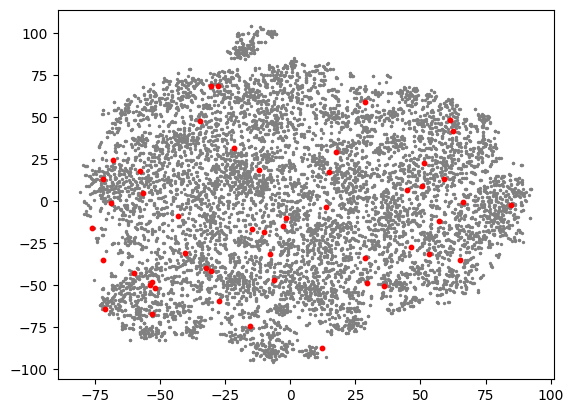

In [107]:
anomaly = res.outlier_score.argsort()[-50:][::-1]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

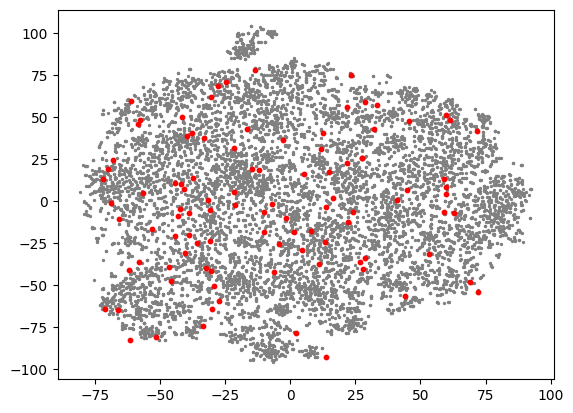

In [8]:
step = (res.rs[1] - res.rs[0])
r_min = res.rs[0]
sqrt_n = int(math.sqrt(res.n_points))
res.outlier_indices = [int((res.sorted_dist[i, sqrt_n] - r_min) / step) for i in range(res.n_points)]
res.scores = np.array(res.scores)
#res.outlier_score = np.array([res.scores[i, res.outlier_indices[i]] for i in range(res.n_points)])
res.outlier_score = np.array([res.scores[i, int((res.sorted_dist[i, sqrt_n] - r_min) / step)] for i in range(res.n_points)])

anomaly = res.outlier_score.argsort()[-100:][::-1]
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

In [127]:
res.outlier_score[5218]

1.1354041026140427

In [29]:
x_sample_tsne = x_tsne[:500]

In [42]:
print(res.sorted_dist[anomaly2, 20].mean())
print(res.sorted_dist[:500, 20].mean())
print(res.sorted_dist[res.sorted_dist[:500, 20].argsort()[-5:], 20])

0.6871191895786511
0.6664664251176068
[0.77207885 0.77354459 0.7807355  0.78995799 0.80635083]


In [143]:
res.outlier_score[res.outlier_score.argsort()[::-1][300]]

1.3645458988908608

In [61]:
non_anomaly = np.flatnonzero(res.outlier_score < 1)

In [20]:
np.argmin(res.scores[1647][180:])

47

In [66]:
for it, i in enumerate(res.sorted_neighbors[9185][:20]):
    print(i, res.outlier_score[i], 1 - res.sorted_dist[9185, it])

9185 0.3757191739064244 1.0
4134 -0.05918258675369054 0.5577733510227172
3773 0.598619501510504 0.5179323973782373
8462 -0.29178030029391455 0.5041183773141629
4249 -0.7843166184503516 0.46947647786157076
678 0.06289839382456602 0.46409548089225705
532 -0.7512068250736634 0.42761798705987897
2071 0.505833578347433 0.41576092031015
6108 0.4397910242557188 0.4057411124598246
827 0.75821759683563 0.40118870990143896
5228 0.32654607151571646 0.39440531887330765
1454 0.2597734977241268 0.3795360576382949
2118 0.5963679247390012 0.3766588923446066
7971 0.31615101624178793 0.3733393086486333
1919 0.6474377020916215 0.3688555567816587
2668 0.45879286514007867 0.3646464492724877
4049 1.015637482434589 0.3603749850782235
1555 -0.4542745733053593 0.358568582800318
3573 0.485900047401699 0.34914862437758787
9240 0.15899858743818493 0.3490050304482666


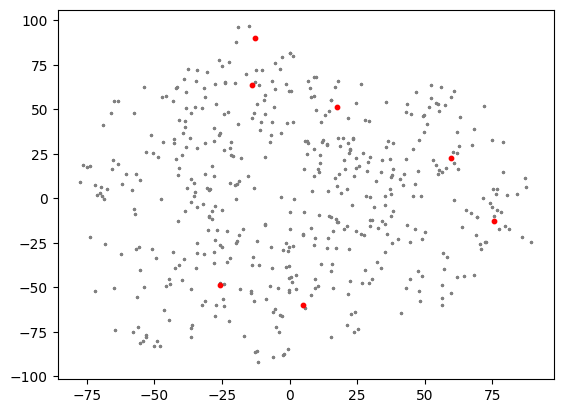

In [103]:

anomaly = res.outlier_score.argsort()[-100:][::-1]
anomaly2 = [i for i in anomaly if i < 500]
anomaly3 = res.sorted_dist[:500, 20].argsort()[-5:]
plt.scatter(x_sample_tsne[:, 0], x_sample_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_sample_tsne[anomaly2, 0], x_sample_tsne[anomaly2, 1], s = 10, color='red')
plt.show()

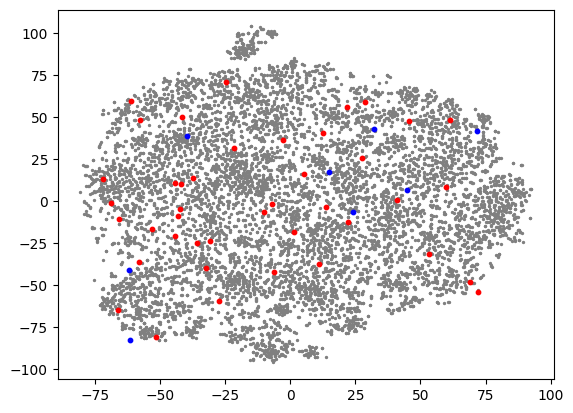

In [133]:
label = '11110110111110111111111101111111110101110111011111'
anomaly = anomaly[:50]
tp = [j for i, j in enumerate(anomaly) if label[i] == '1']
fp = [j for i, j in enumerate(anomaly) if label[i] == '0']
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[tp, 0], x_tsne[tp, 1], s = 10, color='red')
plt.scatter(x_tsne[fp, 0], x_tsne[fp, 1], s = 10, color='blue')
plt.show()

In [55]:
(res.scores[:, 240] > res.scores[3485, 240]).sum()

49

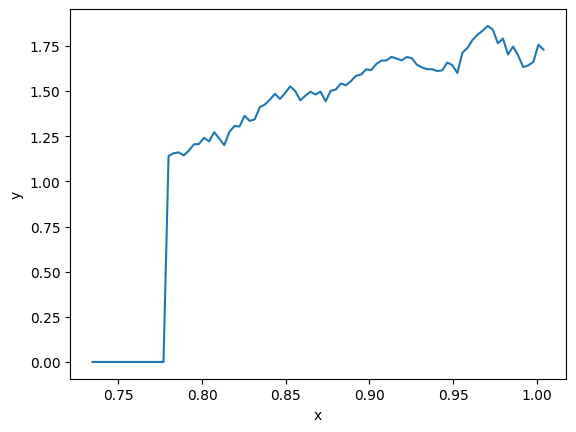

In [52]:

import pandas as pd
import seaborn as sns

linedata = pd.DataFrame({
    'y': [res.scores[3485, k] for k in range(160, len(res.rs), 1)],
    'x': [res.rs[k] for k in range(160, len(res.rs), 1)],
}, columns=['x', 'y'])
sns.lineplot(x="x",
             y="y",
             data=linedata)

plt.show()


In [57]:
res.rs[res.outlier_indices[616]]

0.834443079104808

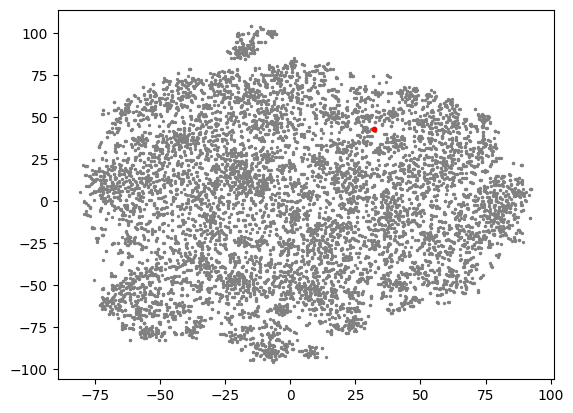

In [113]:
anomaly = res.outlier_score.argsort()[-50:][::-1]
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[[4234], 0], x_tsne[[4234], 1], s = 10, color='red')
plt.show()

In [129]:
for i in anomaly:
    print(interpret_path(paths[i]))

([('property', 'is not', 'unknown / no property'), ('personal_status_sex', 'is', 'married male'), ('status', 'is not', '... >= 200 DM (salary)'), ('duration', 'in', '24 to 31'), ('other_installment_plans', 'is not', 'bank'), ('purpose', 'is not', 'furniture/equipment')], 'reject')
([('telephone', 'is', 'Yes'), ('job', 'is not', 'management/ self-employed/ highly qualified employee/ officer'), ('amount', '<=', 5904), ('present_residence', 'is', '1 to 4 yrs'), ('property', 'is not', 'car or other'), ('installment_rate', 'is not', '< 20 and 20 to 25')], 'accept')
([('status', 'is', '... >= 200 DM (salary)'), ('credit_history', 'is not', 'existing credits paid back duly till now'), ('amount', 'in', '1357 to 1491'), ('other_debtors', 'is', 'none'), ('other_installment_plans', 'is not', 'bank'), ('number_credits', 'is', '1')], 'accept')
([('purpose', 'is not', 'car (new) and furniture/equipment'), ('personal_status_sex', 'is', 'not married male'), ('telephone', 'is', 'No'), ('present_residen

In [93]:
res.outlier_score[res.outlier_score.argsort()[-50:][::-1]]

array([1.81242375, 1.80767886, 1.78966401, 1.78953929, 1.75713243,
       1.75381015, 1.74771078, 1.74419956, 1.73731884, 1.72148037,
       1.71714098, 1.71123606, 1.70971684, 1.70914067, 1.70600345,
       1.70223887, 1.70124351, 1.68483128, 1.67844404, 1.67501449,
       1.66953475, 1.66201002, 1.66092075, 1.65959516, 1.65830554,
       1.65525755, 1.65409493, 1.65127661, 1.64876369, 1.63927103,
       1.63272569, 1.62806504, 1.62184761, 1.62162829, 1.62085559,
       1.62084007, 1.61991311, 1.61649677, 1.61141477, 1.61048634,
       1.60719362, 1.60626457, 1.60532553, 1.60356745, 1.59290624,
       1.58735158, 1.58558786, 1.58345326, 1.58029894, 1.57993553])

In [62]:
rules = []
class_count = {}
all_labels = {}
max_n_conds = 0
top_n = 200
filtered_id = {}
count = 0
idxes = non_anomaly
anomalies = 0
for it, i in enumerate(idxes):
    conds, output = interpret_path(paths[i])
    class_count[output] = class_count.get(output, 0) + 1
    if i in all_labels:
        if all_labels[i] == '1':
            anomalies += 1
        j = it + 1
        if j == 10 or j == 20 or j == 50:
            print('precision@%d: %.2f' % (j, anomalies / j))
    label = all_labels.get(i, -1)
    count += 1
    rules.append({'cond': conds, 'predict': output, 'index': i, 'order': it, 'attr': 0, 'labels': int(label) })
    max_n_conds = max(len(conds), max_n_conds)
conds_per_line = 4
max_n_conds = math.ceil(max_n_conds / conds_per_line) * conds_per_line

f = open('loci_07015.csv', 'w')

for it, rule in enumerate(rules):
    s = '' + str(rule['order'])
    line = 0
    n_conds = len(rule['cond'])
    n_lines = math.ceil(n_conds / conds_per_line)
    index = rule['index']

    for line in range(n_lines):
        if line == 0:
            s += ',#%d,IF,' % (index)
        else:
            s += ',,,'
        for pos in range(conds_per_line):
            i = pos + line * conds_per_line
            if i < n_conds:
                item = rule['cond'][i]
                s += item[0] + ',' + item[1] + ',' + str(item[2]) + ','
                s += 'AND,' if i < n_conds - 1 else '...,'
            else:
                s += '...,...,...,...,'
        if line == n_lines - 1:
            s = s[:-4]
            s += 'THEN,%s,%d,%3f' % (rule['predict'], np.sum(paths[index]['distribution']), paths[index]['confidence'])
        s += '\n'
    f.write(s + '\n')
f.close()

In [26]:
all_labels = {7305: '1', 8624: '0', 1884: '1', 468: '1', 6290: '0', 8055: '0', 2280: '1', 3400: '1', 4466: '0', 4650: '0', 6028: '1', 4459: '1', 1411: '1', 665: '0', 868: '1', 8911: '1', 3848: '0', 9283: '0', 5218: '0', 3035: '0', 1010: '1', 8934: '1', 6483: '1', 2807: '1', 5767: '1', 1763: '1', 4479: '1', 679: '1', 873: '1', 6641: '1', 178: '0', 2278: '1', 7567: '0', 287: '1', 7527: '1', 6569: '1', 3487: '1', 2363: '1', 1750: '0', 2300: '1', 6277: '0', 8240: '1', 7499: '1', 525: '0', 4785: '0', 9324: '0', 3337: '1', 3617: '1', 5003: '1', 2089: '1', 3204: '1', 991: '1', 2167: '1', 3488: '1', 1507: '1', 1840: '1', 4932: '1', 254: '1', 9096: '1', 5974: '0', 7529: '1', 2764: '1', 9134: '1', 2112: '0', 7845: '0', 8073: '1', 4657: '0', 3270: '1', 5502: '1', 616: '1', 6787: '0', 6801: '1', 3486: '1', 405: '1', 3485: '1', 8092: '1', 1393: '0', 668: '1', 8389: '0', 2277: '1', 8629: '0', 1520: '1', 4104: '1', 712: '0', 6952: '1', 1330: '1', 8415: '1', 6471: '1', 690: '1', 5575: '1', 5590: '0', 5252: '0', 2079: '1', 1940: '0', 3891: '1', 2916: '0', 1939: '1', 6839: '0', 4384: '1', 3628: '1', 2664: '1', 8645: '1', 7572: '1', 736: '0', 2228: '1', 4759: '1', 729: '0', 4980: '1', 2009: '1', 2099: '0', 4995: '0', 7810: '1', 7571: '1', 5459: '0', 2817: '0', 4812: '1', 4983: '0', 6289: '0', 8022: '0', 4647: '1', 3618: '1', 9452: '1', 4978: '1', 4350: '1', 2706: '1', 758: '1', 2500: '0', 1017: '0', 7915: '0', 5237: '1', 1963: '1', 7556: '0', 3451: '1', 4977: '1', 7456: '1', 424: '1', 4867: '1', 2279: '1', 4234: '0', 3313: '1', 1703: '1', 9289: '0', 827: '0', 8258: '1'}

In [23]:
for i, label in enumerate('11101000111111101011011110000110101110111101111001'):
    all_labels[anomaly[i]] = label

In [25]:
print(all_labels)

{7305: '1', 8624: '0', 1884: '1', 468: '1', 6290: '0', 8055: '0', 2280: '1', 3400: '1', 4466: '0', 4650: '0', 6028: '1', 4459: '1', 1411: '1', 665: '0', 868: '1', 8911: '1', 3848: '0', 9283: '0', 5218: '0', 3035: '0', 1010: '1', 8934: '1', 6483: '1', 2807: '1', 5767: '1', 1763: '1', 4479: '1', 679: '1', 873: '1', 6641: '1', 178: '0', 2278: '1', 7567: '0', 287: '1', 7527: '1', 6569: '1', 3487: '1', 2363: '1', 1750: '0', 2300: '1', 6277: '0', 8240: '1', 7499: '1', 525: '0', 4785: '0', 9324: '0', 3337: '1', 3617: '1', 5003: '1', 2089: '1', 3204: '1', 991: '1', 2167: '1', 3488: '1', 1507: '1', 1840: '1', 4932: '1', 254: '1', 9096: '1', 5974: '0', 7529: '1', 2764: '1', 9134: '1', 2112: '0', 7845: '0', 8073: '1', 4657: '0', 3270: '1', 5502: '1', 616: '1', 6787: '0', 6801: '1', 3486: '1', 405: '1', 3485: '1', 8092: '1', 1393: '0', 668: '1', 8389: '0', 2277: '1', 8629: '0', 1520: '1', 4104: '1', 712: '0', 6952: '1', 1330: '1', 8415: '1', 6471: '1', 690: '1', 5575: '1', 5590: '0', 5252: '0', 20